Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: c:\Users\HP\AppData\Local\Temp\tmpyz4s5_51
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3453/3453 ━━━━━━━━━━━━━━━━━━━━ 71s 20ms/step - loss: 2.8736e-04
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
RMSE: 3.1420518467495584
BLEU Score: 0


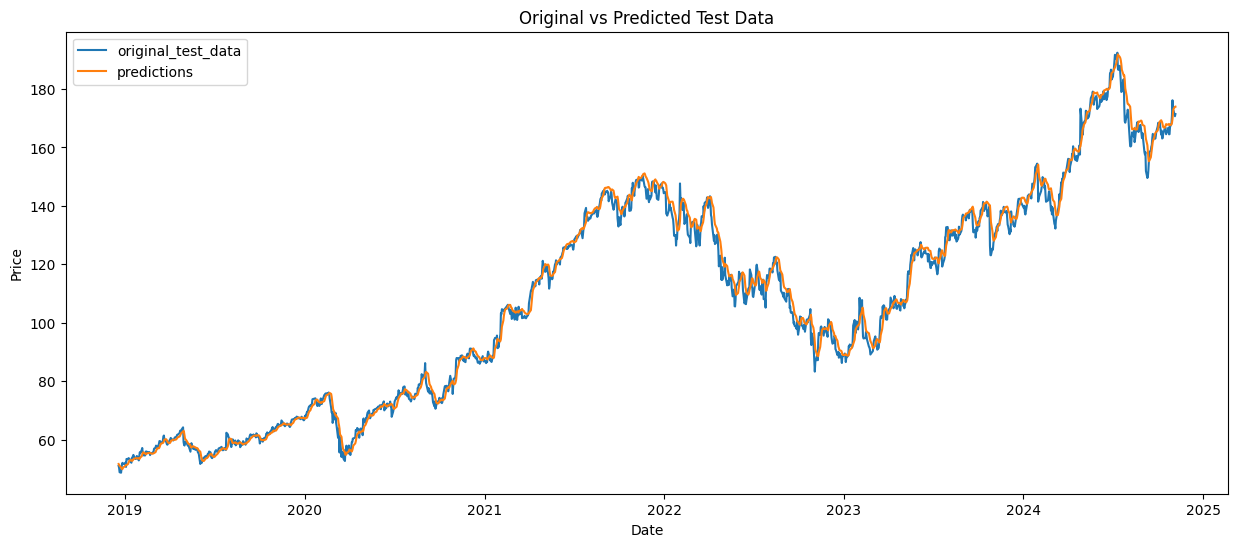

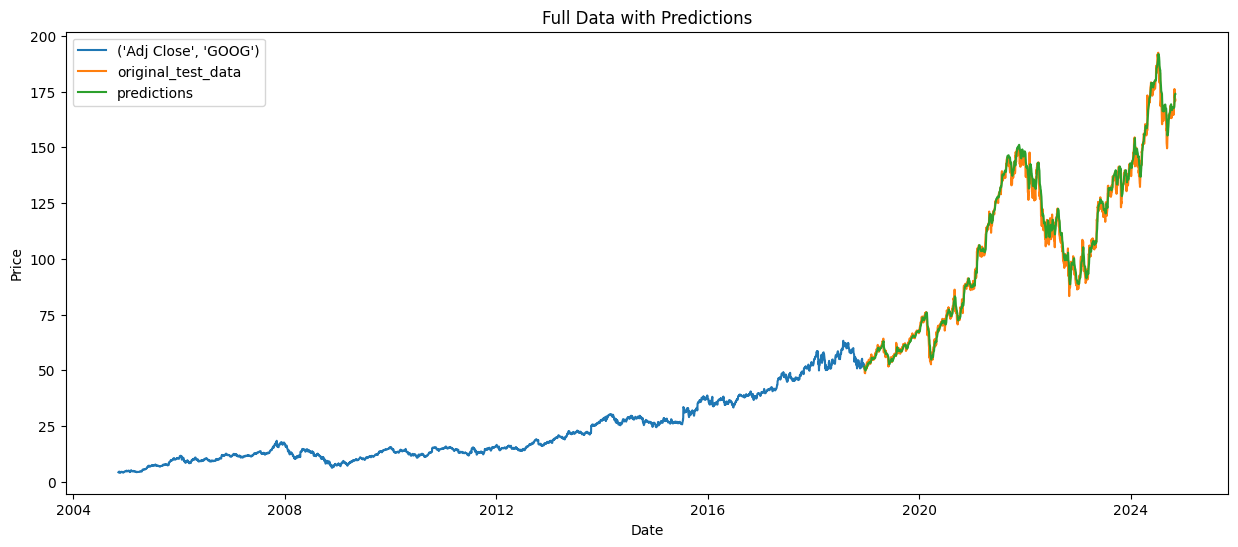

In [ ]:
# Install necessary packages
!pip install yfinance
!python -m ensurepip --upgrade
!python -m pip install --upgrade pip
!pip install --upgrade pybind11 scipy scikit-learn

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Set up date range
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

# Download data
stock = "GOOG"
google_data = yf.download(stock, start=start, end=end)

# Prepare data for plotting and modeling
Adj_close_price = google_data[['Adj Close']]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Adj_close_price)

# Create sequences
x_data = []
y_data = []
for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i-100:i])
    y_data.append(scaled_data[i])

x_data, y_data = np.array(x_data), np.array(y_data)

# Split data into training and test sets
splitting_len = int(len(x_data) * 0.7)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]
x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=10)

# Make predictions
predictions = model.predict(x_test)
inv_predictions = scaler.inverse_transform(predictions)  # Inverse scaling for predictions
inv_y_test = scaler.inverse_transform(y_test)           # Inverse scaling for actual test data

# Calculate RMSE
rmse = np.sqrt(np.mean((inv_predictions - inv_y_test) ** 2))
print("RMSE:", rmse)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Convert the actual and predicted values into strings, simulating 'sequences'
# required by BLEU (each value is converted to a 'token' for BLEU compatibility)
reference = [[str(val) for val in inv_y_test.flatten()]]
candidate = [str(val) for val in inv_predictions.flatten()]

# Use smoothing to handle the lack of n-gram overlaps
smooth = SmoothingFunction().method1

# Calculate BLEU score
bleu_score = sentence_bleu(reference, candidate, smoothing_function=smooth)
print("BLEU Score:", bleu_score)

# Prepare data for plotting
plotting_data = pd.DataFrame({
    'original_test_data': inv_y_test.reshape(-1),
    'predictions': inv_predictions.reshape(-1)
}, index=google_data.index[splitting_len+100:])

# Plotting functions
def plot_graph(figsize, data, title):
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(data.columns)
    plt.show()

# Plot original vs. predicted test data
plot_graph((15, 6), plotting_data, "Original vs Predicted Test Data")

# Plot full data with predictions appended
full_data = pd.concat([Adj_close_price[:splitting_len+100], plotting_data], axis=0)
plot_graph((15, 6), full_data, "Full Data with Predictions")

# Save the model
model.save("Latest_stock_price_model.keras")
